# objective 
20230816
sarahfong

learn the features of the US MPRA dataset

do some basic transformations and comparisons 

## transformations
- per replicate 
    
    - log2 normalize activity values
    - explore standard scaling log2 values (rep ctrl 2 has wider variance than other replicates) 

- across replicates
    - compute median, mean, sd of log2 values, standard scaling values 

## questions
- what is the variance between replicates? 
- How well do replicates correlate with one another?
    - pearson between replicates? 
    - spearman between replicates? 
- what is the correlation across replicate means, medians within group?

- is there are difference between log2 ratio and standard scaling activity? 

In [1]:
import config_readwrite as crw

import matplotlib.pyplot as plt
import numpy as np
import os, sys

import pandas as pd

import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection, multipletests
from sklearn.preprocessing import RobustScaler, StandardScaler

from plot_params import fonts

# Read, write to config

In [2]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

# path
DATA_PATH = config["local_path"]["data"]

# make dictionary of values to write to config
config_dict = {
    "HEPG2": os.path.join(DATA_PATH, "full_hepg2_ultrasound_MPRA.csv"),
    "HEPG2.clean": os.path.join(DATA_PATH, "full_hepg2_ultrasound_MPRA.clean.csv"),
    "HEPG2.clean.transformed": os.path.join(DATA_PATH, "full_hepg2_ultrasound_MPRA.clean.transformed.csv"),
    "HEPG2.clean.trans.scaled": os.path.join(DATA_PATH, "full_hepg2_ultrasound_MPRA.clean.transformed.standard.scaled.csv"),
    "BJ": os.path.join(DATA_PATH, "full_bj_ultrasound_MPRA.csv"),
    "BJ.clean": os.path.join(DATA_PATH, "full_bj_ultrasound_MPRA.clean.csv"),
    "BJ.clean.transformed": os.path.join(DATA_PATH, "full_bj_ultrasound_MPRA.clean.transformed.csv"),
    "BJ.clean.trans.scaled": os.path.join(DATA_PATH, "full_bj_ultrasound_MPRA.clean.transformed.standard.scaled.csv"),
    "FASTA":os.path.join(DATA_PATH, "ultrasound_final_no_adapter.fasta")
}

# make data section of config
section = "data"
crw.check(config, section)

# add dictionary to config
for key, value in config_dict.items():
    config[section][key] = value
    
# write to config    
crw.write(config, cfn)

# functions

In [3]:
def cohensd(test, ctrl):
    cohens_d = (np.mean(test) - np.mean(ctrl)) / (np.sqrt((np.std(test) ** 2 + np.std(ctrl) ** 2) / 2))
    return cohens_d

## mean, median, std

In [4]:
def computeStats(df, l2_ratios_list):
    """ compute median, mean, std of ctrl and ultrasound replicates per sequence"""
    
    df["l2.ratio.med.ctrl"] = df[l2_ratios_list[:3]].median(axis=1)
    df["l2.ratio.mean.ctrl"] = df[l2_ratios_list[:3]].mean(axis=1)
    df["l2.ratio.std.ctrl"] = df[l2_ratios_list[:3]].std(axis=1)

    df["l2.ratio.med.us"] = df[l2_ratios_list[3:]].median(axis=1)
    df["l2.ratio.mean.us"] = df[l2_ratios_list[3:]].mean(axis=1)
    df["l2.ratio.std.us"] = df[l2_ratios_list[3:]].std(axis=1)
    
    return df

## l2 transform (RNA/DNA) 

In [5]:
def log2Transform(df, ratios_list):
    """ log2 transform each ratio column"""
    
    for ratio in ratios_list:
        df[f"l2.{ratio}"] = np.log2(df[ratio])
    
    return df

## get coordinates

In [6]:
def getCoordinates(df):
    """str split name to get genomic coordinates for endogenous sequences"""
    
    coordf = df.loc[df['name'].str.contains("chr")].copy()

    coordf["coor"] = coordf["name"].apply(
        lambda x: "chr"+x.split("chr")[1] if "chr" in x else None)

    # merge- add coordinates back to dataframe
    return pd.merge(df, coordf, how="left")

 ## compute fold change of medians 

In [7]:
def computeDelta(df):
    """ compute delta of log2 median us - log2 median control"""
    
    df["delta.med"] = df["l2.ratio.med.us"]-df["l2.ratio.med.ctrl"]
    df["delta.mean"] = df["l2.ratio.mean.us"]-df["l2.ratio.mean.ctrl"]
    
    return df

In [8]:
def clOrigin(df, constants_list):
    """annotate which cl a sequence was designed from"""
    
    df["cl.origin"] = None

    for cl in constants_list:
        df.loc[df['name'].str.contains(cl), "cl.origin"] = cl
    
    return df

In [9]:
def ctrlAnnot(df, constants_list):
    """ annotate control type (pos, neg, test)"""
    
    df["type"] = "None"
    for ctrl in constants_list:
        df.loc[df['label'].str.contains(ctrl), "type"] = ctrl
    
    return df

In [10]:
def computePval(df, constants_list):
    """ compute per sequence ttest of ctrl v. ultrasound rep
        assume equal_var is False 
        
        perform FDR correction per assay type - 'DEG', 'atac', 'k27ac', 'neg', 'pos', 'shuffle', 'synthetic'
    """
    df["pval"] = None
    for i, row in df.iterrows():

        # get control replicates
        ctrls = row[constants_list[:3]]

         # get US replicates
        uss = row[constants_list[3:]]
        
        # t-test per sequence, no equal variance assumed. 
        t,p = stats.ttest_ind(list(ctrls), list(uss), equal_var=False)
        
        # update dataframe
        df.at[i,'pval'] = p
    
    # perform 
    fdr_correction = {}
    
    # FDR alpha=0.05 pvalue correction within dataset
    for t in set(df["type"]):
        test = df.loc[df["type"]==t].copy()
        
        test["fdr_bool"], test["fdr_p"]= fdrcorrection(test["pval"])
        test["bonferroni_bool"], test["bonferroni_p"], sidak, bone = fdrcorrection(test["pval"], alpha=0.05, method="bonferroni")

        print(test.groupby("fdr_bool")["name"].count())
        fdr_correction[t] = test
        
    return pd.concat(fdr_correction.values())

In [11]:
def bootstrap(data_list, size, stat):
    """
    return the discrete and relative 95% confidence intervals of a data_list 

    input
        list of data (list, continuous values) - any list of data values, must be continuous values. 
        size (int) - size of dataset to bootstrap from list. If None, make bootstrapped distribution from entire list
        stat (float or "mean") - quantile to bootstrap (float, 0-1) or mean (str)

    method 
        1. If size is None, get the length of the list 
        2. get the observed stat of the list (mean, median, quantile)
        3. set bootstrap parameters
        4. per iteration, randomly choose elements from the fold changes list w replacement
        5. append the stat to the list of bootstrapped_stat
        6. turn stats into a dataframe
        7. calculate the delta distances from the population stat. This centers the data.
        8. sort from largest to smallest difference
        9. get discrete 0.025 adn 0.975 quantile values of the centered stat distribution. 
        10. calculate relative confidence intervals and actual confidence interval values (population stat - quantile values)
    """

    # 1
    if size is None:
        size = len(data_list)  # size of distribution to bootstrap

    # 2
    if type(stat) is float:
        obs_stat = np.quantile(data_list, stat)  # get observed stat

    elif stat == "mean":
        obs_stat = np.mean(data_list)  # get observed stat

    # 3
    nboot = 10000  # resample 10000 times
    val = 0
    bs_stats = []

    # 4
    while val < nboot:

        bs_dist = np.random.choice(data_list, replace=True, size=size)

        # 5
        if type(stat) is float:
            bs_stat = np.quantile(bs_dist, stat)

        elif stat == "mean":
            bs_stat = np.mean(bs_dist)

        bs_stats.append(bs_stat)
        val += 1
    # 6
    bs = pd.DataFrame(data=bs_stats,
                      index=np.arange(nboot),
                      columns=["bs_stat"])  # make dataframe of bootstraps

    # 7 center the stat distribution
    bs["deltas"] = bs["bs_stat"] - obs_stat

    # 8
    bs = bs.sort_values(by="deltas", ascending=False)

    # 9  get discrete 95th CI
    low = bs.deltas.quantile(0.025)
    high = bs.deltas.quantile(0.975)
    ci_relative = [high, low]  # assume obs value is centered at zero

    # 10  return ci relative to observed stat
    ci_discrete = obs_stat - [high, low]  # assume obs value is center

    print(f"measure CI of {stat} quantile| mean estimate\n observed {stat} value:",
          obs_stat,
          "\ndiscrete diff from observed:", ci_discrete,
          "\nrelative diff from observed:", ci_relative)
    return ci_discrete, ci_relative

In [12]:
def callActive(df):
    """call active elements from ctrl, us MPRA as values > 95 of shuffled regions"""
    
    # get shuffles
    shufs = df.loc[df.name.str.contains("shuf")].copy()
    
    # get 97.5% of shuffle median score for ctrl, US treatment
    ctrl_975 = shufs['l2.ratio.med.ctrl'].quantile(0.975)
    us_975 = shufs['l2.ratio.med.us'].quantile(0.975)
    
    
    ctrl_025 = shufs['l2.ratio.med.ctrl'].quantile(0.025)
    us_025 = shufs['l2.ratio.med.us'].quantile(0.025)
    print(ctrl_975,ctrl_025, us_975, us_025)

    # create column to label active
    df['label.ctrl'], df['label.us']=False, False
    
    # label active elements - has more activity than 97.5% shuffles
    df.loc[df['l2.ratio.med.ctrl']>ctrl_975, 'label.ctrl']=True
    df.loc[df['l2.ratio.med.us']>us_975, 'label.us']=True

    # label active elements - has less activity than 2.5% shuffles
    df.loc[df['l2.ratio.med.ctrl']<ctrl_025, 'label.ctrl']=True
    df.loc[df['l2.ratio.med.us']<us_025, 'label.us']=True
    
    return df

In [13]:
def callResponse(df):
    df["response"] = False
    
    df.loc[(df["pval"]<0.005)&
          (df['label.ctrl']!=df['label.us']),
           "response"
          ] = True
    
    return df

# get enhancer info

In [20]:
PEAKS = os.path.join(DATA_PATH, "tiles.x.atac_k27ac_diff.bed")
p = pd.read_csv(PEAKS, sep='\t')

enh = {}
for row in p.iterrows():
    enh_id, name = row[1]["enh_id"], row[1]["name"]
    if enh_id not in enh.keys():
        enh[enh_id] = [name]
        
    elif enh_id in enh.keys():
        name_lst = enh[enh_id]
        name_lst.append(name)
        enh[enh_id] = name_lst

# test cell line 

## notes about this dataset
- Activity score - median score was assigned per US|CTRL for each sequence
- Active | inactive = test sequence score > 95% shuffled score. Both these scores are median score (above)
- logFC
- P-value

## Params

### constants dict

In [14]:
constants = {
    "NAMES" :['name',
         'label',
         'ratio.med.ctrl',
         'label.ctrl',
         'ratio.1.ctrl',
         'ratio.2.ctrl',
         'ratio.3.ctrl',
         'ratio.med.us',
         'label.us',
         'ratio.1.us',
         'ratio.2.us',
         'ratio.3.us',
         'pval',
         'logFC',
         'response'],
    
    "CTRL_LIST" : ["neg", "pos", "shuffle", "synthetic", 'k27ac', "atac", "DEG"],
    
    "RATIOS": ['ratio.1.ctrl','ratio.2.ctrl', 'ratio.3.ctrl', 
          'ratio.1.us', 'ratio.2.us','ratio.3.us'],
    
    "L2RATIOS": ['l2.ratio.1.ctrl','l2.ratio.2.ctrl', 'l2.ratio.3.ctrl', 
          'l2.ratio.1.us', 'l2.ratio.2.us','l2.ratio.3.us'],
    
    "CL_LIST" :["k562", "hob", "bj", "hepg2"]
}

### input data

multiple colinearities - do group-wise difference

In [ ]:
CL = "BJ"
DATA = config_dict[CL]
CLEAN = config_dict[f"{CL}.clean.transformed"]
SCALED =config_dict[f'{CL}.clean.trans.scaled']

## LOAD

In [15]:
### load data

#if os.path.exists(CLEAN) is False:
# load .csv data, rename columns, skip row 1 (old column names)
df_ = pd.read_csv(DATA, skiprows=1, names=constants["NAMES"], low_memory=False)

# annotate cell line origin
df = clOrigin(df_, constants["CL_LIST"])

# annotate controls
df = ctrlAnnot(df,constants["CTRL_LIST"])

# coordinates
df = getCoordinates(df)

# log2 transform ratios - increase sensitivity for ratios <1
df = log2Transform(df, constants["RATIOS"])

In [16]:
df.head()

,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,ratio.1.us,...,response,cl.origin,type,coor,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us
0,SYNTHETIC:_The_motif_AAAATTGCTGACTTG_was_added...,synthetic,0.866094,inactive,0.869807,0.843118,0.866094,0.641978,inactive,0.626618,...,unresponsive,None,synthetic,NaN,-0.201233,-0.246194,-0.207404,-0.674342,-0.639405,-0.619921
1,SYNTHETIC:_Added_TTCCCCCC_TTGCTGCTCTAG_GGCGCAT...,synthetic,0.557800,inactive,0.557709,0.572204,0.557800,0.465300,inactive,0.478723,...,unresponsive,None,synthetic,NaN,-0.842415,-0.805399,-0.842180,-1.062738,-1.110539,-1.103767
2,SYNTHETIC:_Added_TCCTTATCTC_CACCTG_GTTCGAGACCA...,synthetic,0.708102,inactive,0.695024,0.708102,0.712623,0.594116,inactive,0.582323,...,unresponsive,None,synthetic,NaN,-0.524865,-0.497970,-0.488788,-0.780110,-0.724969,-0.751185
3,k562_atac_down_chr1:232594398-232594667,atac,0.741191,inactive,0.736186,0.741191,0.748069,0.815399,inactive,0.817265,...,unresponsive,k562,atac,chr1:232594398-232594667,-0.441858,-0.432082,-0.418757,-0.291125,-0.315290,-0.294422
4,hob_k27ac_up_chr7:38841102-38841371,k27ac,0.686201,inactive,0.686201,0.664392,0.696646,0.839775,inactive,0.839775,...,unresponsive,hob,k27ac,chr7:38841102-38841371,-0.543297,-0.589893,-0.521503,-0.251925,-0.268875,-0.226339


# compute enhancer-wise test

In [34]:
test = df[constants["L2RATIOS"] + ["name"]]

# drop the ratio 2
test = test.drop(columns="l2.ratio.2.ctrl")

v = 0
for ENH in enh.keys():

    TILES = enh[ENH]

    t = test.loc[test["name"].isin(TILES)].copy()
    if len(t)>0:

        tm = t.melt(id_vars='name') # melt data

        tm["group"] = tm["variable"].apply(lambda x: x.split(".")[-1]) # make us and ctrl groups

        s, p = stats.mannwhitneyu(tm.loc[tm["group"]=="ctrl", "value"], 
                          tm.loc[tm["group"] !="ctrl", "value"])

        if p<0.05:
            print(ENH, len(TILES), p)

            v+=1
    else:
        #print("missing", ENH, TILES)
        continue

,l2.ratio.1.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,name
0,-0.201233,-0.207404,-0.674342,-0.639405,-0.619921,SYNTHETIC:_The_motif_AAAATTGCTGACTTG_was_added...
1,-0.842415,-0.842180,-1.062738,-1.110539,-1.103767,SYNTHETIC:_Added_TTCCCCCC_TTGCTGCTCTAG_GGCGCAT...
2,-0.524865,-0.488788,-0.780110,-0.724969,-0.751185,SYNTHETIC:_Added_TCCTTATCTC_CACCTG_GTTCGAGACCA...
3,-0.441858,-0.418757,-0.291125,-0.315290,-0.294422,k562_atac_down_chr1:232594398-232594667
4,-0.543297,-0.521503,-0.251925,-0.268875,-0.226339,hob_k27ac_up_chr7:38841102-38841371


In [59]:
syn = {}
for i in test.iterrows():
    name = i[1]["name"]
    if "SYNTHETIC" in name:
        print()
        break

(0, l2.ratio.1.ctrl                                            -0.201233
l2.ratio.3.ctrl                                            -0.207404
l2.ratio.1.us                                              -0.674342
l2.ratio.2.us                                              -0.639405
l2.ratio.3.us                                              -0.619921
name               SYNTHETIC:_The_motif_AAAATTGCTGACTTG_was_added...
Name: 0, dtype: object)


In [67]:
syns = test.loc[test.name.str.contains("TGTAACAA")].copy()

In [68]:
syns.head()

,l2.ratio.1.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,name
24,-1.268550,-1.167918,-0.640753,-0.510989,-0.533635,SYNTHETIC:_Added_ATGCTGAC_TTTTATAA_GTATCAAAGT_...
66,-0.111009,-0.061873,-0.337360,-0.397199,-0.464448,SYNTHETIC:_Added_AGGGGAGGTATT_GGCCGTCTGG_TTGCT...
104,-0.409805,-0.461134,-0.788880,-0.799683,-0.728840,SYNTHETIC:_Added_ATGCTGAC_GGCCGTCTGG_AATTA_CCT...
126,0.110919,-0.046886,-0.658400,-0.497314,-0.354025,SYNTHETIC:_Added_AGGTGTCA_AATTA_TTCCCCCC_CCCCT...
215,-2.726938,-2.648183,-1.792493,-2.040810,-1.751923,SYNTHETIC:_Added_TGAGGTCA_GCCCGGGGG_TGTAACAA_a...


In [69]:
sm = pd.melt(syns, id_vars ="name")
sm["group"] = sm["variable"].apply(lambda x: x.split(".")[-1]) # make us and ctrl groups

In [71]:
 s, p = stats.mannwhitneyu(sm.loc[sm["group"]=="ctrl", "value"], 
                          sm.loc[sm["group"] !="ctrl", "value"])
s,p

(22077064.0, 0.5223920846691317)

In [ ]:
# compute stats
df = computeStats(df, constants["L2RATIOS"])

# compute difference between scaled
df = computeDelta(df)

# recall active
df = callActive(df)

# re compute pvalues 
df = computePval(df, constants["L2RATIOS"])

# recall response
df = callResponse(df)
# write the file

df.to_csv(CLEAN, sep='\t', index=False)
print('wrote clean')

In [16]:
else:
    df = pd.read_csv(CLEAN, sep='\t')

df.head()

,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,ratio.1.us,...,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean
0,SYNTHETIC:_The_motif_AAAATTGCTGACTTG_was_added...,synthetic,0.866094,False,0.869807,0.843118,0.866094,0.641978,False,0.626618,...,-0.639405,-0.619921,-0.207404,-0.218277,0.024373,-0.639405,-0.644556,0.027574,-0.432001,-0.426279
1,SYNTHETIC:_Added_TTCCCCCC_TTGCTGCTCTAG_GGCGCAT...,synthetic,0.557800,False,0.557709,0.572204,0.557800,0.465300,False,0.478723,...,-1.110539,-1.103767,-0.842180,-0.829998,0.021304,-1.103767,-1.092348,0.025865,-0.261587,-0.262350
2,SYNTHETIC:_Added_TCCTTATCTC_CACCTG_GTTCGAGACCA...,synthetic,0.708102,False,0.695024,0.708102,0.712623,0.594116,False,0.582323,...,-0.724969,-0.751185,-0.497970,-0.503875,0.018749,-0.751185,-0.752088,0.027582,-0.253214,-0.248213
3,k562_atac_down_chr1:232594398-232594667,atac,0.741191,False,0.736186,0.741191,0.748069,0.815399,False,0.817265,...,-0.315290,-0.294422,-0.432082,-0.430899,0.011596,-0.294422,-0.300279,0.013104,0.137660,0.130620
4,hob_k27ac_up_chr7:38841102-38841371,k27ac,0.686201,False,0.686201,0.664392,0.696646,0.839775,False,0.839775,...,-0.268875,-0.226339,-0.543297,-0.551564,0.034937,-0.251925,-0.249046,0.021413,0.291372,0.302518


## QC old df v. new df

In [17]:
def harmonizeOldDf(df_):
    df_.loc[df_["label.ctrl"] == "inactive", "label.ctrl"] = False
    df_.loc[df_["label.ctrl"] == "active", "label.ctrl"] = True
    df_.loc[df_["label.us"] == "inactive", "label.us"] = False
    df_.loc[df_["label.us"] == "active", "label.us"] = True
    
    df_.loc[df_["response"] =="ultrasound-responsive", "response" ] = True
    df_.loc[df_["response"] =="unresponsive", "response" ] = False
    
    return df_

In [18]:
def checkCoor(old_df, new_df, col):
    """
    check correlations before and after log transforming data
    """
    old_col = 'old-'+col
    
    old = old_df[["name", col]].drop_duplicates()
    new = new_df[["name", col]].drop_duplicates()
    
    old = old.rename(columns={col:'old-'+col})

    print(list(old), list(new))
    
    m = pd.merge(old[["name", 'old-'+col]], 
                 new 
                )
    print(m[[old_col, col]].corr())

### harmonize old df with bool

In [19]:
# load .csv data, rename columns, skip row 1 (old column names)
df_ = pd.read_csv(DATA, skiprows=1, names=constants["NAMES"], low_memory=False)

df_ = harmonizeOldDf(df_)

### check pval correlation after log2 transformation

In [20]:
checkCoor(df_, df, "pval")

['name', 'old-pval'] ['name', 'pval']
          old-pval      pval
old-pval  1.000000  0.987211
pval      0.987211  1.000000


### check label correlation - ctrl

In [21]:
checkCoor(df_, df, "label.ctrl")  # calling activity in control

['name', 'old-label.ctrl'] ['name', 'label.ctrl']
                old-label.ctrl  label.ctrl
old-label.ctrl        1.000000    0.867419
label.ctrl            0.867419    1.000000


### check label correlation - us

In [22]:
checkCoor(df_, df, "label.us")  # calling activity in US

['name', 'old-label.us'] ['name', 'label.us']
              old-label.us  label.us
old-label.us      1.000000  0.812358
label.us          0.812358  1.000000


In [23]:
checkCoor(df_, df, "response")

['name', 'old-response'] ['name', 'response']
              old-response  response
old-response      1.000000  0.470756
response          0.470756  1.000000


not sure if response column rules are correct. Correct according to methods. 

## Within group replicate correlation? 

### plot function

In [24]:
def plotCorrHeatMap(data,cols):
    """ plot pearson and spearman correlation between columns in a dataframe"""
    pearson = data[cols].corr()
    spearman = data[cols].corr(method="spearman")
    
    matrix_p = np.triu(pearson)
    matrix_s = np.triu(spearman)
    
    # pearson
    fig,ax=plt.subplots()
    sns.heatmap(pearson, 
                annot=True, 
                mask=matrix_p,
                center=0,
                cbar_kws={"label":"pearson"}) 

    # spearman
    fig,ax=plt.subplots()
    sns.heatmap(spearman, 
                annot=True,
                mask=matrix_s,
                center=0,
                cbar_kws={"label":"spearman"})

### within replicates, Pearson, Spearman

In [25]:
constants.keys()

dict_keys(['NAMES', 'CTRL_LIST', 'RATIOS', 'L2RATIOS', 'CL_LIST'])

In [26]:
ratios=constants["L2RATIOS"]

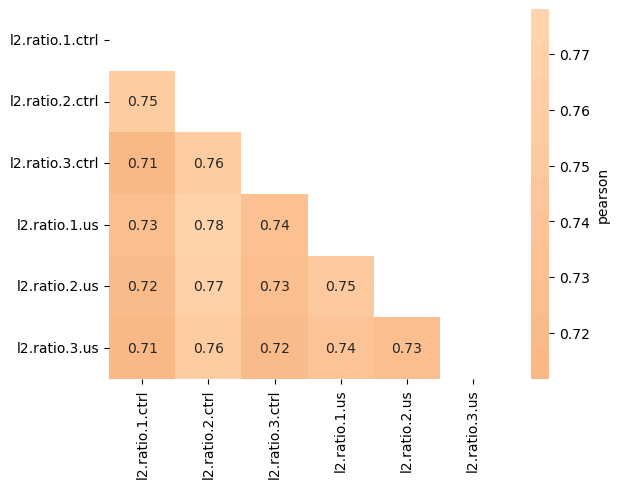

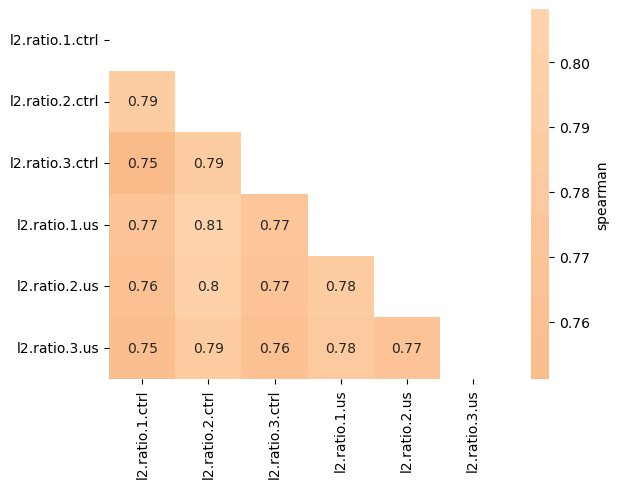

In [27]:
data = df
cols = ratios

plotCorrHeatMap(data,cols)

### problem = control 2 has greater variance. 

[Text(0.5, 0, 'log2(RNA/DNA)')]

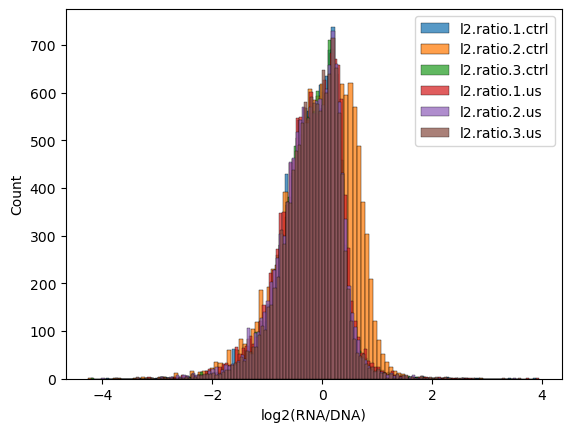

In [28]:
fig,ax=plt.subplots()

for col in ratios:
    sns.histplot(data[col].sample(frac=0.2), label=col)
plt.legend()
ax.set(xlabel = 'log2(RNA/DNA)')

# Standard scaling per replicate

In [29]:
if os.path.exists(SCALED) is False:
    X = df[ratios]

    transformer = StandardScaler()

    t = pd.DataFrame(transformer.fit_transform(X[ratios]))

    t.columns = ratios # rename columns 

    ### mean, median of standardized values

    t = computeStats(t, ratios)

    # compute delta
    t = computeDelta(t)

    ### compute p value on standardized scale
    t = computePval(t, ratios)

    # add back names
    t = pd.merge(df['name'], t, left_index=True,right_index=True)

    # recall active
    t = callActive(t)

    # recall response
    t = callResponse(t)

    # write
    t.to_csv(SCALED, sep='\t', index=False)


else:
    t= pd.read_csv(SCALED, sep='\t')
t.head()

,name,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,pval,label.ctrl,label.us,response
0,SYNTHETIC:_The_motif_AAAATTGCTGACTTG_was_added...,0.015399,-0.258578,-0.007015,-0.808657,-0.793191,-0.805267,-0.007015,-0.083398,0.152124,-0.805267,-0.802372,0.008129,-0.798252,-0.718974,0.014394,False,False,False
1,SYNTHETIC:_Added_TTCCCCCC_TTGCTGCTCTAG_GGCGCAT...,-1.191758,-1.110089,-1.226916,-1.492076,-1.660092,-1.734303,-1.191758,-1.176254,0.059936,-1.660092,-1.628824,0.124104,-0.468334,-0.452570,0.011969,False,False,False
2,SYNTHETIC:_Added_TCCTTATCTC_CACCTG_GTTCGAGACCA...,-0.593905,-0.641962,-0.547775,-0.994765,-0.950632,-1.057307,-0.593905,-0.594547,0.047097,-0.994765,-1.000901,0.053602,-0.400860,-0.406354,0.000643,False,False,False
3,k562_atac_down_chr1:232594398-232594667,-0.437628,-0.541633,-0.413189,-0.134352,-0.196811,-0.180275,-0.437628,-0.464150,0.068206,-0.180275,-0.170479,0.032361,0.257353,0.293671,0.007776,False,False,False
4,hob_k27ac_up_chr7:38841102-38841371,-0.628606,-0.781934,-0.610644,-0.065375,-0.111405,-0.049549,-0.628606,-0.673728,0.094139,-0.065375,-0.075443,0.032133,0.563231,0.598285,0.004279,False,False,False


In [30]:
SCALED

'/wynton/home/ahituv/fongsl/EMF/US/data/full_bj_ultrasound_MPRA.clean.transformed.standard.scaled.csv'

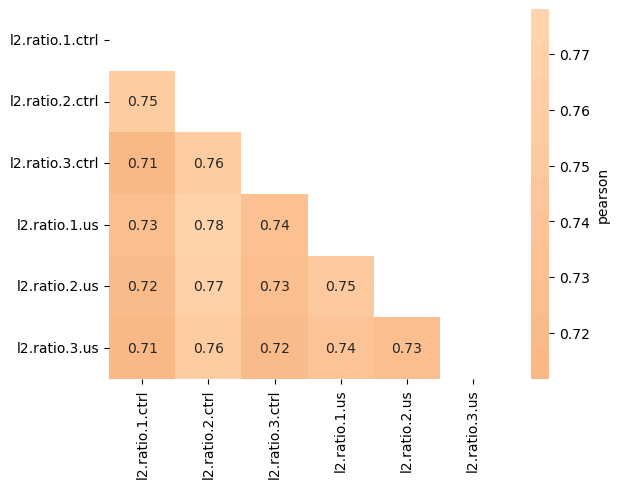

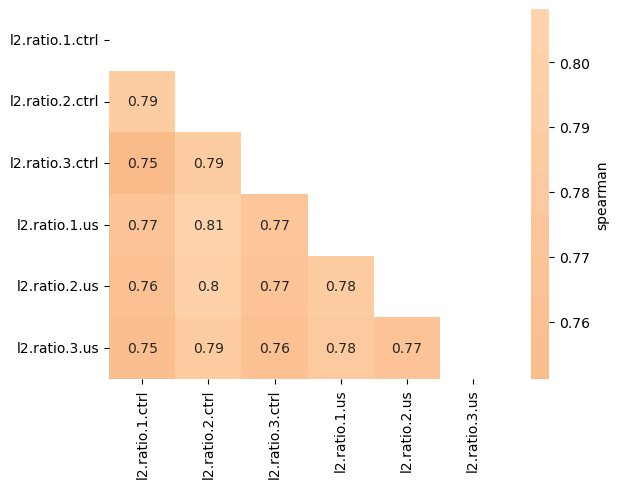

In [31]:
data = t
cols = ratios

plotCorrHeatMap(data,cols)

##### After transform, the correlations between the sets are still the same
##### but the values are scaled to account for variance between replicates

[Text(0.5, 0, 'log2(RNA/DNA)')]

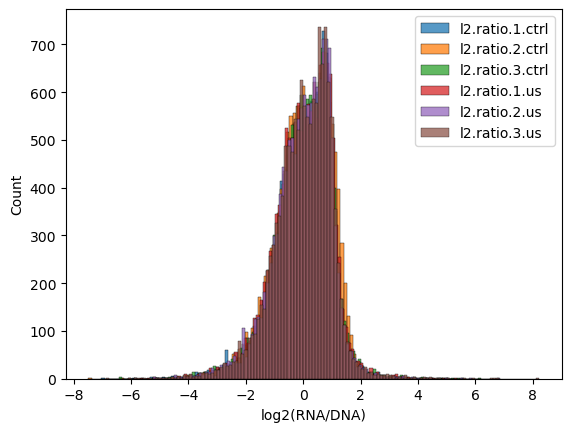

In [32]:
fig,ax=plt.subplots()
for col in ratios:
    sns.histplot(data[col].sample(frac=0.2), label=col)
plt.legend()
ax.set(xlabel = 'log2(RNA/DNA)')

# bootstrap 95ci

In [33]:
bootstrap(df["delta.med"], None)

CI [0.0010516251549867954, -0.0011794365626037959] [-0.03361296 -0.03138189] -0.0325613300605614


([0.0010516251549867954, -0.0011794365626037959],
 array([-0.03361296, -0.03138189]))

# US v. ctrl

## mean / median correlations

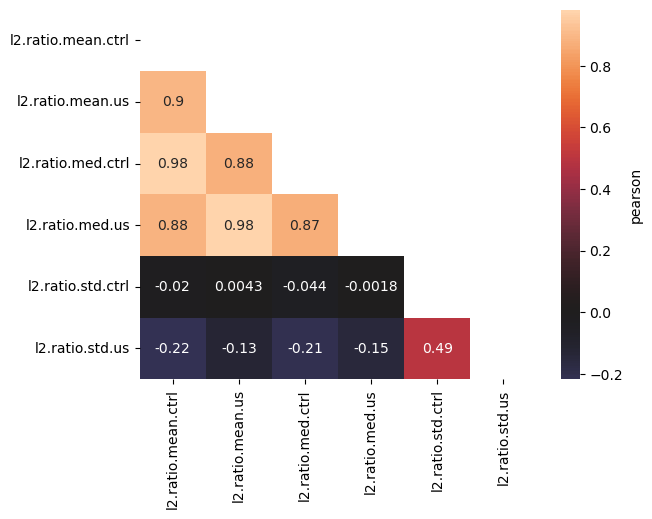

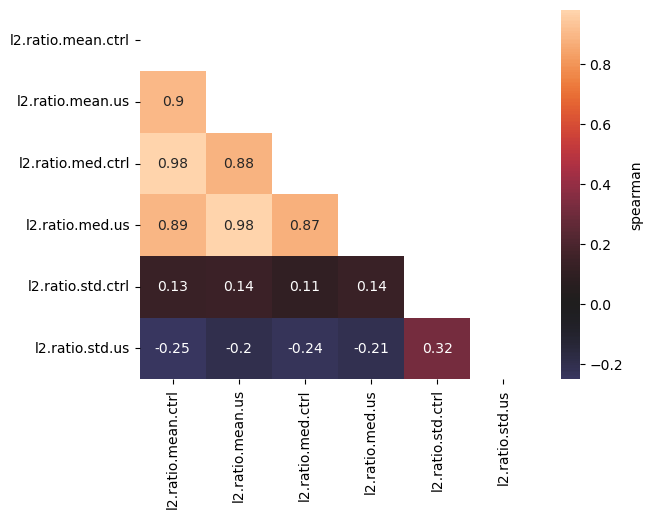

In [34]:
data = df
cols = ['l2.ratio.mean.ctrl', 'l2.ratio.mean.us',
        'l2.ratio.med.ctrl','l2.ratio.med.us', 
        'l2.ratio.std.ctrl','l2.ratio.std.us']

plotCorrHeatMap(data,cols)

In [35]:
data[cols].describe()

,l2.ratio.mean.ctrl,l2.ratio.mean.us,l2.ratio.med.ctrl,l2.ratio.med.us,l2.ratio.std.ctrl,l2.ratio.std.us
count,67847.000000,67847.000000,67847.000000,67847.000000,67847.000000,67847.000000
mean,-0.163182,-0.207878,-0.183996,-0.210657,0.237394,0.191887
std,0.518805,0.494535,0.507837,0.501876,0.194051,0.202921
min,-3.275023,-3.664295,-3.385148,-4.018783,0.000494,0.000433
25%,-0.474375,-0.505590,-0.479234,-0.509474,0.119180,0.071778
50%,-0.107923,-0.155296,-0.119329,-0.156751,0.191763,0.130156
75%,0.239755,0.172042,0.201040,0.170404,0.290776,0.230364
max,4.028838,4.134341,3.884995,4.127671,2.758937,2.857186


## mean/ median scaled correlations

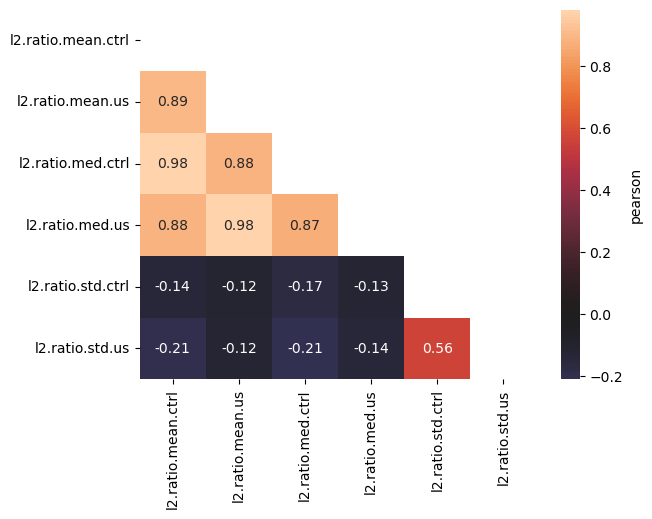

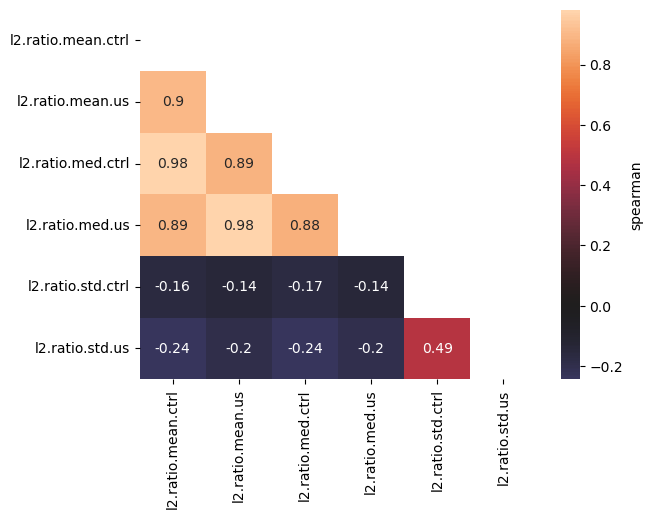

In [37]:
# transformed data
data = t

plotCorrHeatMap(data,cols)

In [38]:
data[cols].describe()

,l2.ratio.mean.ctrl,l2.ratio.mean.us,l2.ratio.med.ctrl,l2.ratio.med.us,l2.ratio.std.ctrl,l2.ratio.std.us
count,6.784700e+04,6.784700e+04,67847.000000,67847.000000,67847.000000,67847.000000
mean,2.262108e-17,1.382399e-17,-0.007461,-0.004929,0.358982,0.349369
std,9.098384e-01,9.085647e-01,0.918554,0.922131,0.359782,0.373800
min,-5.599958e+00,-6.265468e+00,-5.786636,-7.011350,0.000721,0.001140
25%,-5.428437e-01,-5.466951e-01,-0.553449,-0.555420,0.146072,0.127986
50%,9.794970e-02,9.673750e-02,0.091916,0.094155,0.254336,0.235555
75%,7.048293e-01,6.978622e-01,0.699604,0.695709,0.431243,0.420298
max,7.417989e+00,7.986211e+00,7.708561,7.978373,5.215262,5.330628


In [39]:
ps = pd.merge(t[["name", 'pval']], df[["name", 'pval']], right_on = "name", left_on="name", suffixes = ("_transformed", "_not_transformed"))

In [40]:
ps.head()

,name,pval_transformed,pval_not_transformed
0,SYNTHETIC:_The_motif_AAAATTGCTGACTTG_was_added...,0.014394,0.000041
1,SYNTHETIC:_Added_TTCCCCCC_TTGCTGCTCTAG_GGCGCAT...,0.011969,0.000213
2,SYNTHETIC:_Added_TCCTTATCTC_CACCTG_GTTCGAGACCA...,0.000643,0.000433
3,k562_atac_down_chr1:232594398-232594667,0.007776,0.000225
4,hob_k27ac_up_chr7:38841102-38841371,0.004279,0.000617


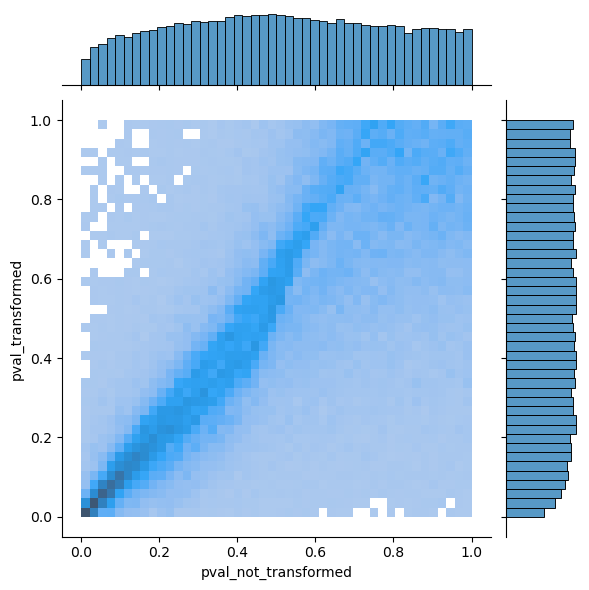

In [41]:
ps_cols =["pval_not_transformed", "pval_transformed"]
sns.jointplot(x=ps_cols[0], y=ps_cols[1], data=ps, kind='hist')

In [42]:
ps[ps_cols].corr(method="spearman")

,pval_not_transformed,pval_transformed
pval_not_transformed,1.000000,0.745203
pval_transformed,0.745203,1.000000


## plots

### logFC distribution of datatypes

<Axes: xlabel='logFC', ylabel='Density'>

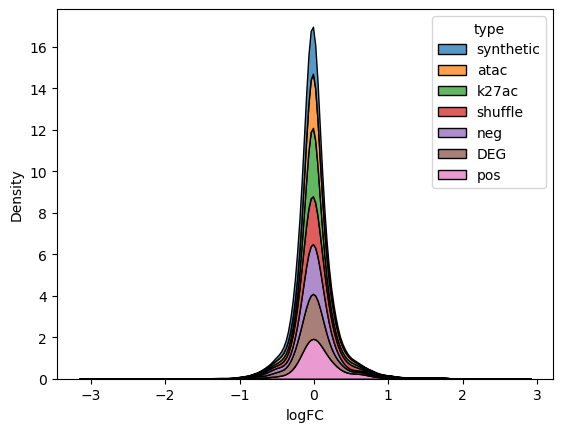

In [43]:
col = "logFC"
sns.kdeplot(x=col, data=df, hue= "type", common_norm=False,
            multiple="stack"
           )

In [44]:
set(df.type)

{'DEG', 'atac', 'k27ac', 'neg', 'pos', 'shuffle', 'synthetic'}

In [45]:
labels=["atac", "pos", "k27ac", "DEG", "neg"]
simpledf = df.loc[df["type"].isin(labels)]

[(-1.0, 1.0), Text(0.5, 0, 'l2fc')]

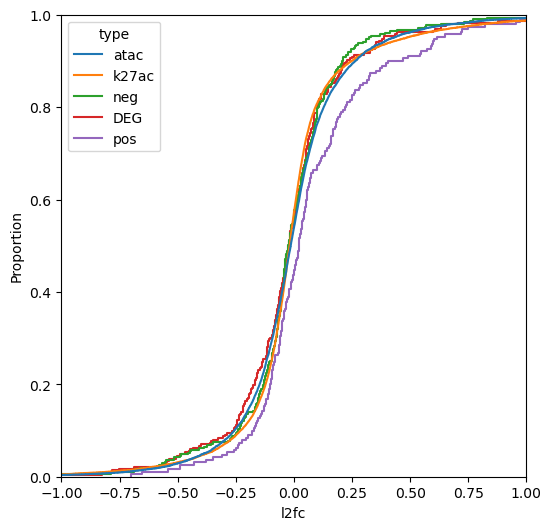

In [46]:
col = "logFC"
data=simpledf
fig, ax= plt.subplots(figsize=(6,6))
sns.ecdfplot(x=col, data=data, hue= "type", 
             #common_norm=False, 
             #multiple="stack",
            #stat="percent"
           )
ax.set(xlim=(-1,1), 
      xlabel="l2fc")

In [47]:
# add type information back into transformed dataframe
t = pd.merge(t, df[["name", "type"]])

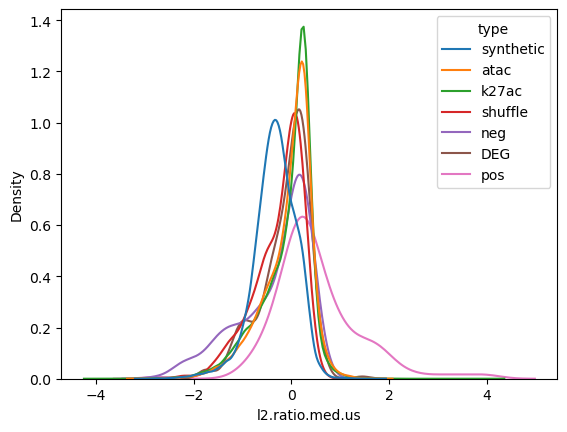

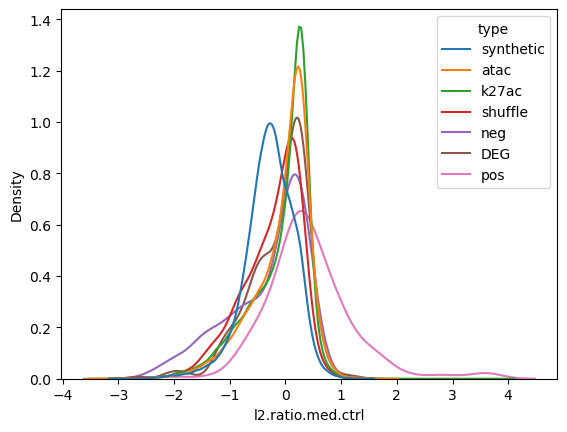

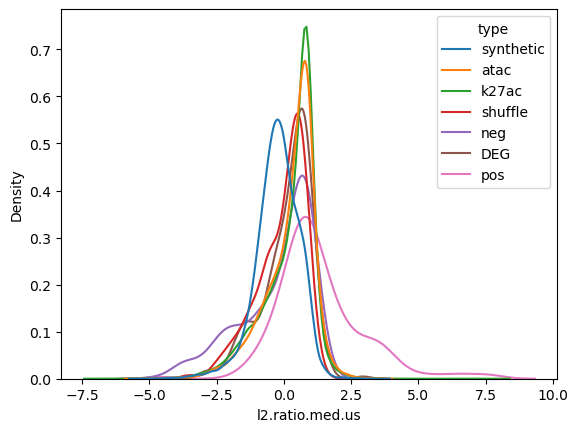

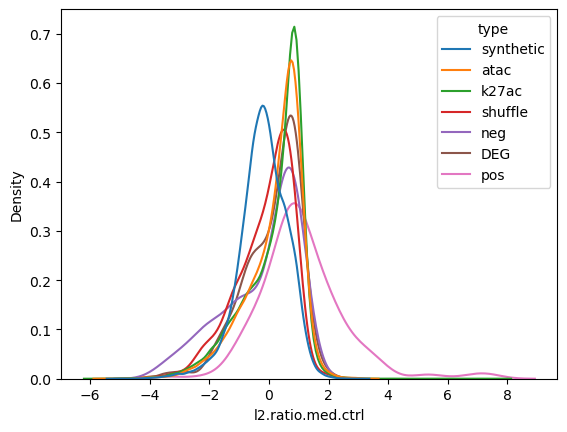

In [48]:
cols = ["l2.ratio.med.us", "l2.ratio.med.ctrl"]
datas = [df, t]
for data in datas:
    for col in cols:
        fig, ax = plt.subplots()
        sns.kdeplot(x=col, data=data, label = col, hue="type", common_norm=False)

# correlation between ctrl x US
- raw values. Need to be centered per ctrl/US condition?

In [49]:
data_dict = {"raw":(df, [-4,5]),
            'standardized': (t, [-6,9])}

## median

In [53]:
def jointPlot(x, y, data, id_, **kwargs):
    
    out = kwargs.get('out', None)
    
    # pick color
    if "med" in x:
        color = "b"
    elif "mean" in x:
        color = "g"
    else:
        color="orange"
        
        
    sns.jointplot(x=x,
                  y=y,
                  data=data.loc[data["pval"]<0.05], 
                  color=color,
                  marginal_ticks=True, 
                  alpha=0.2
             )

    # don't plot identity line when looking at fc
    #if "delta" not in y:
     #   plt.plot(id_,id_, c="k", ls="--")
    
    # axes
    plt.axhline(0, c="grey", ls="--")
    plt.axvline(0, c="grey", ls="--")
    
    if out is not None:
        plt.savefig(out, bbox_inches='tight')
        

In [51]:
# change datatype
df["pval"] = df["pval"].astype(float)
t["pval"] = t["pval"].astype(float)

df["-log10p"] = np.log10(df["pval"])*-1
t["-log10p"] = np.log10(t["pval"])*-1

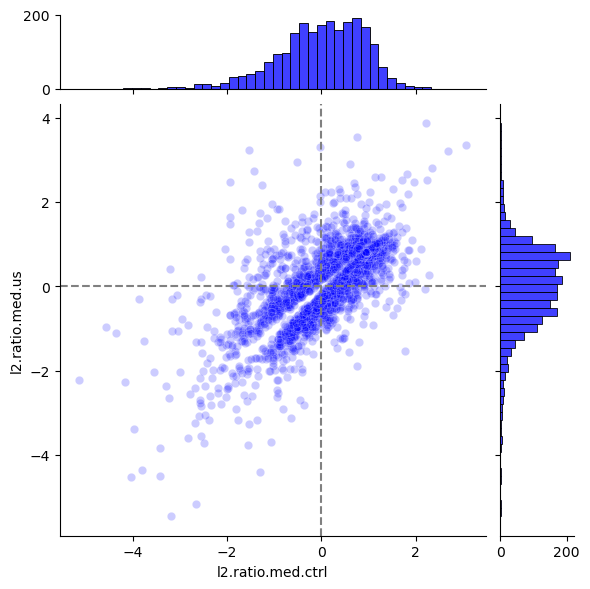

In [54]:
x="l2.ratio.med.ctrl"
y="l2.ratio.med.us"

data, id_ = data_dict["standardized"]

jointPlot(x, y, data, id_)

### activity x fold change

In [55]:
data.head()

,name,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,...,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,pval,label.ctrl,label.us,response,type,-log10p
0,SYNTHETIC:_The_motif_AAAATTGCTGACTTG_was_added...,0.015399,-0.258578,-0.007015,-0.808657,-0.793191,-0.805267,-0.007015,-0.083398,0.152124,...,-0.802372,0.008129,-0.798252,-0.718974,0.014394,False,False,False,synthetic,1.841824
1,SYNTHETIC:_Added_TTCCCCCC_TTGCTGCTCTAG_GGCGCAT...,-1.191758,-1.110089,-1.226916,-1.492076,-1.660092,-1.734303,-1.191758,-1.176254,0.059936,...,-1.628824,0.124104,-0.468334,-0.452570,0.011969,False,False,False,synthetic,1.921933
2,SYNTHETIC:_Added_TCCTTATCTC_CACCTG_GTTCGAGACCA...,-0.593905,-0.641962,-0.547775,-0.994765,-0.950632,-1.057307,-0.593905,-0.594547,0.047097,...,-1.000901,0.053602,-0.400860,-0.406354,0.000643,False,False,False,synthetic,3.192002
3,k562_atac_down_chr1:232594398-232594667,-0.437628,-0.541633,-0.413189,-0.134352,-0.196811,-0.180275,-0.437628,-0.464150,0.068206,...,-0.170479,0.032361,0.257353,0.293671,0.007776,False,False,False,atac,2.109253
4,hob_k27ac_up_chr7:38841102-38841371,-0.628606,-0.781934,-0.610644,-0.065375,-0.111405,-0.049549,-0.628606,-0.673728,0.094139,...,-0.075443,0.032133,0.563231,0.598285,0.004279,False,False,False,k27ac,2.368648


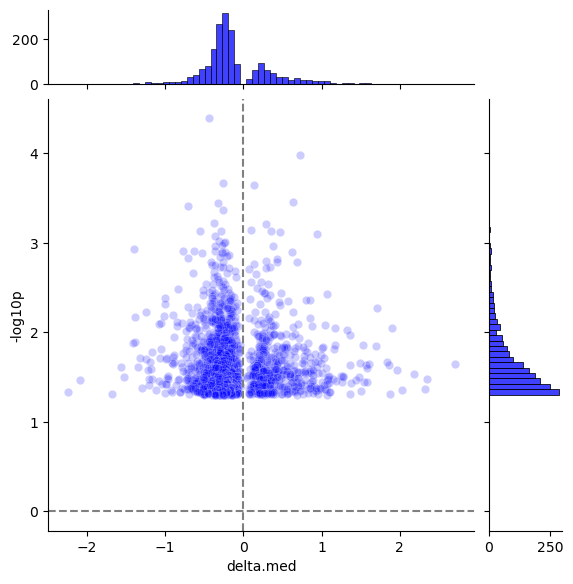

In [83]:
x= "delta.med"
y= "-log10p"

data, id_ = data_dict["raw"]

id_ = [1,3]
out = c"delta.median.{CL}.pdf"
jointPlot(x, y, data, id_)

In [ ]:
x= "delta.med"
y= "-log10p"

data, id_ = data_dict["raw"]

id_ = [1,3]
jointPlot(x, y, data, id_)

In [84]:
data["mean.var.us"] = data["l2.ratio.mean.us"]/data["l2.ratio.std.us"]

In [130]:
data["mean.var.us"].describe()

count    67847.000000
mean        -1.429583
std         10.722222
min       -719.329935
25%         -3.343218
50%         -0.859201
75%          1.243816
max        647.916870
Name: mean.var.us, dtype: float64

[]

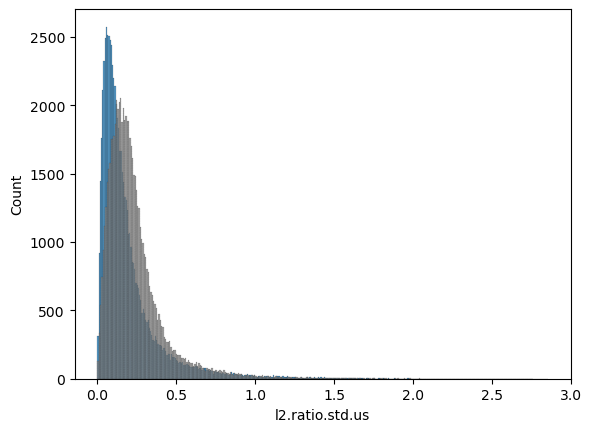

In [131]:
sns.histplot(data["l2.ratio.std.us"])
sns.histplot(data["l2.ratio.std.ctrl"],color="grey", ls="--")
ax.plot()

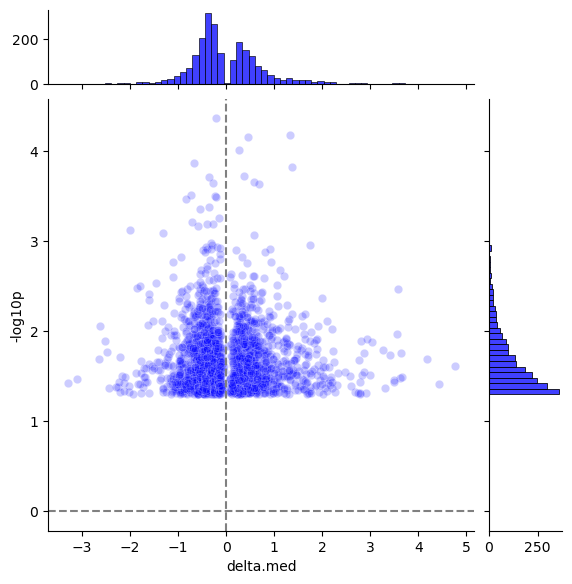

In [132]:
x="delta.med"
y= "-log10p"
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

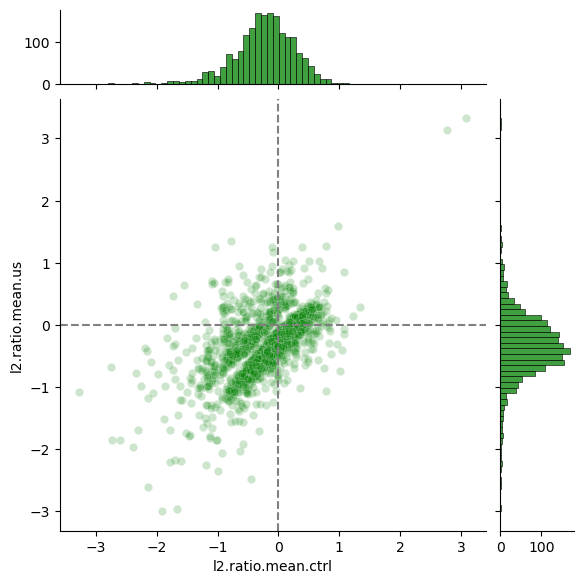

In [133]:
x= "l2.ratio.mean.ctrl"
y="l2.ratio.mean.us"

data, id_ = data_dict["raw"]

jointPlot(x, y, data, id_)

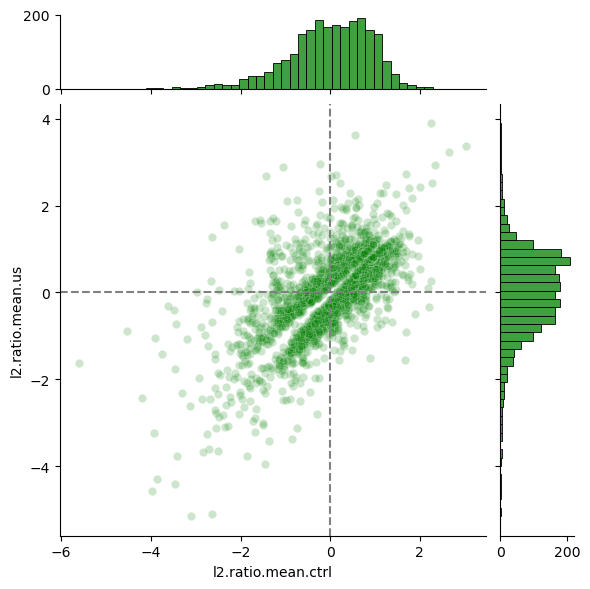

In [134]:
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

In [ ]:
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

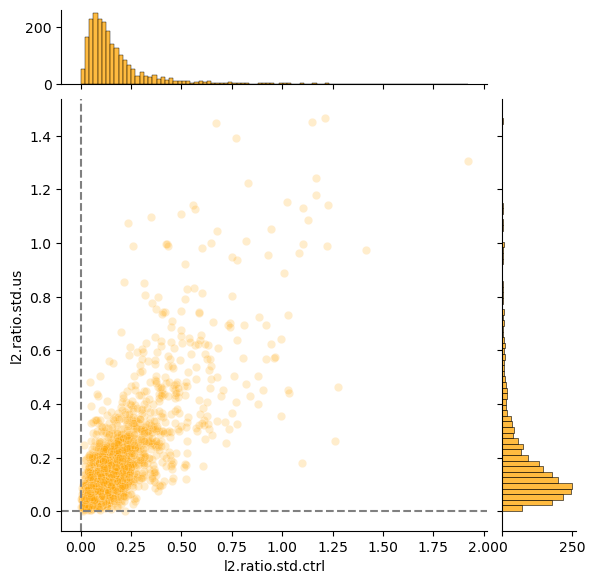

In [136]:
x= "l2.ratio.std.ctrl"
y="l2.ratio.std.us"
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

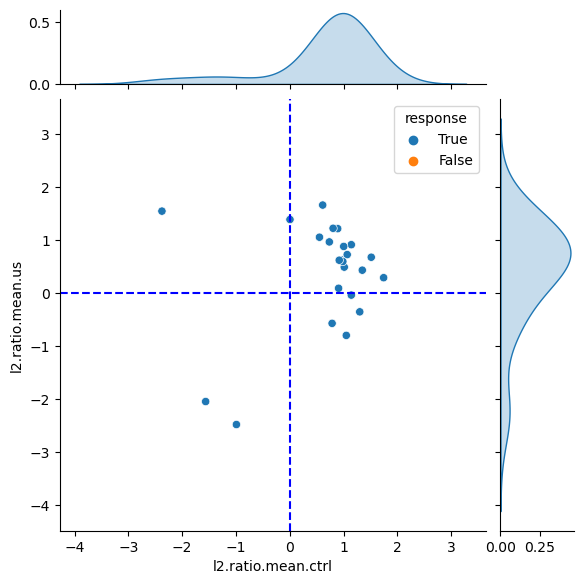

In [146]:
data, id_ = data_dict["standardized"] 
sns.jointplot(y="l2.ratio.mean.us", data=data.loc[data["response"]==True], x= "l2.ratio.mean.ctrl", 
                marginal_ticks=True, 
                hue_order = [True, False],
               hue='response')


#plt.plot(id_,id_, c="k", ls="--")
plt.axhline(0, c="b", ls="--")
plt.axvline(0, c="b", ls="--")

# p-value distribution 

In [137]:
df["pval"] = df["pval"].astype(float)

In [138]:
df["pval"].describe()

count    67847.000000
mean         0.514446
std          0.270790
min          0.000041
25%          0.293416
50%          0.511057
75%          0.740093
max          0.999994
Name: pval, dtype: float64

<Axes: xlabel='pval', ylabel='Count'>

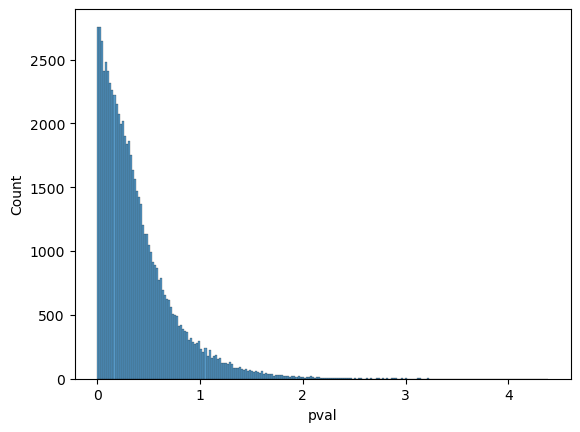

In [139]:
sns.histplot(np.log10(df["pval"])*-1)

In [140]:
len(df.loc[df["pval"]<0.05])

1874

In [141]:
import pylab

In [142]:
np.array(df["pval"])

array([4.08494919e-05, 2.13319734e-04, 4.33186148e-04, ...,
       9.56353382e-01, 8.54999925e-01, 9.61950459e-01])

((array([-4.26011089, -4.05751977, -3.94718773, ...,  3.94718773,
          4.05751977,  4.26011089]),
  array([4.08494919e-05, 1.03624148e-04, 2.13319734e-04, ...,
         9.99970834e-01, 9.99981882e-01, 9.99993840e-01])),
 (0.26630483587012305, 0.5144455293694614, 0.9833833390930337))

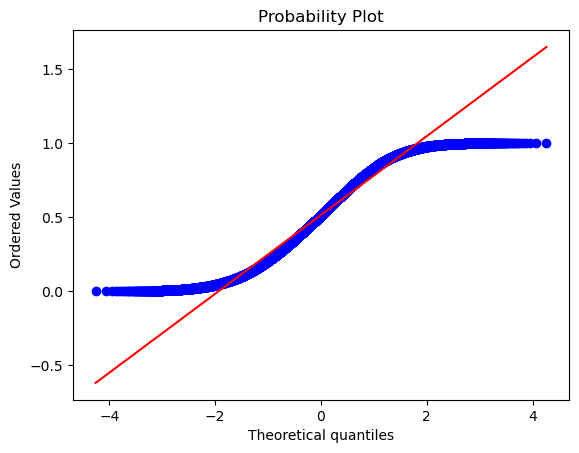

In [143]:
stats.probplot(np.array(df["pval"]), dist="norm", plot=pylab)
#pylab.show()

((array([-4.26011089, -4.05751977, -3.94718773, ...,  3.94718773,
          4.05751977,  4.26011089]),
  array([4.31032376e-05, 6.64088435e-05, 6.95308861e-05, ...,
         9.99988374e-01, 9.99995206e-01, 9.99999631e-01])),
 (0.27516766371656715, 0.5128043958222547, 0.9792289636418502))

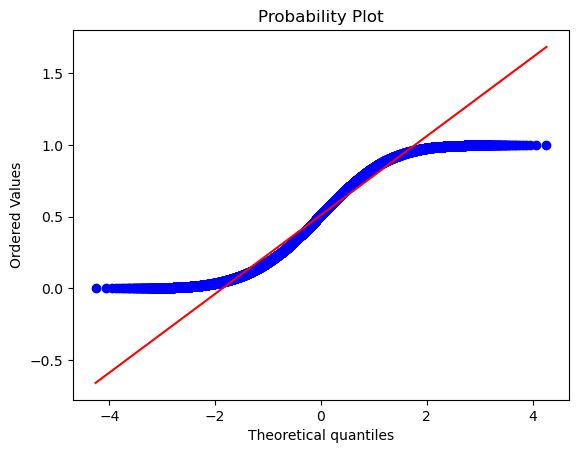

In [144]:
stats.probplot(np.array(t["pval"]), dist="norm", plot=pylab)
#pylab.show()

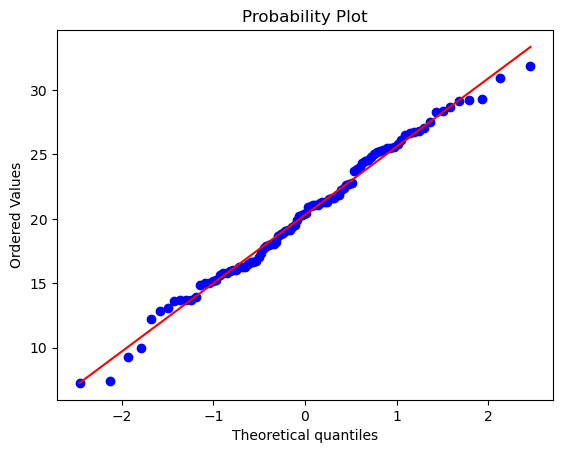

In [145]:
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()